In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
train_df = pd.read_csv("../data/train_model.csv")
val_df   = pd.read_csv("../data/val_model.csv")
test_df  = pd.read_csv("../data/test_model.csv")

# Detectar la columna de texto
TEXT_COL = None
for col in ["clean_body", "text", "body"]:
    if col in train_df.columns:
        TEXT_COL = col
        break

# Detectar el label
LABEL_COL = None
for col in ["rule_violation", "label", "target"]:
    if col in train_df.columns:
        LABEL_COL = col
        break

print("TEXT_COL:", TEXT_COL)
print("LABEL_COL:", LABEL_COL)

TEXT_COL: clean_body
LABEL_COL: rule_violation


In [17]:
X_train = train_df[TEXT_COL].astype(str).tolist()
y_train = train_df[LABEL_COL].astype(int).tolist()

X_val   = val_df[TEXT_COL].astype(str).tolist()
y_val   = val_df[LABEL_COL].astype(int).tolist()

# test puede NO tener labels, depende del archivo
has_test_labels = LABEL_COL in test_df.columns

X_test = test_df[TEXT_COL].astype(str).tolist()

if has_test_labels:
    y_test = test_df[LABEL_COL].astype(int).tolist()


In [18]:
MODEL_NAME = "microsoft/deberta-v3-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_texts(texts, labels=None, batch_size=64):
    enc = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="tf"
    )

    if labels is not None:
        return tf.data.Dataset.from_tensor_slices((dict(enc), labels)).batch(batch_size)
    else:
        return tf.data.Dataset.from_tensor_slices(dict(enc)).batch(batch_size)

train_ds = tokenize_texts(X_train, y_train)
val_ds   = tokenize_texts(X_val, y_val)

if has_test_labels:
    test_ds = tokenize_texts(X_test, y_test)
else:
    test_ds = tokenize_texts(X_test)

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [19]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="./Modelo_Deberta/best_weights",
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1,
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=1,
    restore_best_weights=True,
    verbose=1,
)

reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    mode="min",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)


In [20]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['cls_dropout', 'classifier', 'pooler']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduceLR_cb]
)

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5385 
Epoch 1: val_accuracy improved from -inf to 0.66749, saving model to ./Modelo_Deberta\best_weights
26/26 [==============================] - 1246s 43s/step - loss: 0.6874 - accuracy: 0.5385 - val_loss: 0.6198 - val_accuracy: 0.6675 - lr: 3.0000e-05
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.5604 - accuracy: 0.7086 
Epoch 2: val_accuracy improved from 0.66749 to 0.70690, saving model to ./Modelo_Deberta\best_weights
26/26 [==============================] - 894s 34s/step - loss: 0.5604 - accuracy: 0.7086 - val_loss: 0.6149 - val_accuracy: 0.7069 - lr: 3.0000e-05
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.7880 
Epoch 3: val_accuracy improved from 0.70690 to 0.76847, saving model to ./Modelo_Deberta\best_weights
26/26 [==============================] - 857s 33s/step - loss: 0.4573 - accuracy: 0.7880 - val_loss: 0.5078 - val_a

In [25]:
VAL_PATH = "../data/val_model.csv" 

val_df = pd.read_csv(VAL_PATH)

TEXT_COL  = "clean_body"
LABEL_COL = "rule_violation"

X_val = val_df[TEXT_COL].astype(str).tolist()
y_val = val_df[LABEL_COL].astype(int).values



In [26]:
val_enc = tokenizer(
    X_val,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="tf"
)

val_ds = tf.data.Dataset.from_tensor_slices((
    dict(val_enc),
    y_val
)).batch(32)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# 1. Predicciones
pred = model.predict(val_ds)
pred_logits = pred.logits
pred_labels = tf.argmax(pred_logits, axis=1).numpy()

# 2. Reporte de clasificación
print(classification_report(y_val, pred_labels))

13/13 [==============================] - 40s 3s/step
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       200
           1       0.78      0.78      0.78       206

    accuracy                           0.77       406
   macro avg       0.77      0.77      0.77       406
weighted avg       0.77      0.77      0.77       406



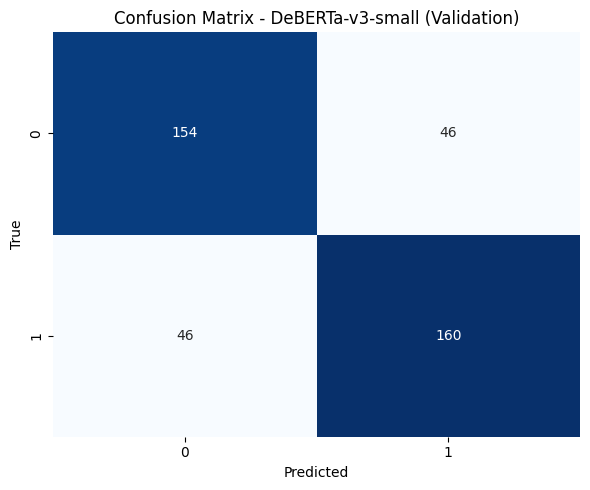


Confusion Matrix Table:



,Pred 0,Pred 1
True 0,154,46
True 1,46,160


In [28]:
cm = confusion_matrix(y_val, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - DeBERTa-v3-small (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 4. Tabla tipo dataframe
cm_df = pd.DataFrame(
    cm,
    index=["True 0", "True 1"],
    columns=["Pred 0", "Pred 1"]
)

print("\nConfusion Matrix Table:\n")
display(cm_df)
